In [51]:
import pandas as pd

In [52]:
shutoken_df = pd.read_excel("/home/ubuntu/grs/exp/20241125/data/1125/売上データ_選別MK全データ_アイテム別_20240229.xlsx", sheet_name='首都圏卸')
shogyo_df = pd.read_excel("/home/ubuntu/grs/exp/20241125/data/1125/売上データ_選別MK全データ_アイテム別_20240229.xlsx", sheet_name='商業施設')

recent_df = pd.read_excel("/home/ubuntu/grs/exp/20241125/data/1125/241125_AI需要予測送付用.xlsx", sheet_name='Sheet1')

In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

def plot_sales(sales_series_list, labels, start_month_day, end_month_day):
    """
    Plot sales data for multiple Series with yearly segmentation and month-day range filtering.

    Args:
        sales_series_list (list of pd.Series): List of Series containing sales data with DateTimeIndex.
        labels (list of str): List of labels for the corresponding Series.
        start_month_day (str): Start month and day for filtering in 'MM-DD' format.
        end_month_day (str): End month and day for filtering in 'MM-DD' format.

    Returns:
        None
    """
    plt.figure(figsize=(15, 8))

    # Convert start_month_day and end_month_day to comparable tuples
    start_month_day = tuple(map(int, start_month_day.split('-')))
    end_month_day = tuple(map(int, end_month_day.split('-')))

    for sales_series, label in zip(sales_series_list, labels):
        # Ensure the Series is sorted by date
        sales_series = sales_series.sort_index()

        # Filter data based on month and day
        sales_series = sales_series[
            sales_series.index.map(lambda x: (x.month, x.day)) >= start_month_day
        ]
        sales_series = sales_series[
            sales_series.index.map(lambda x: (x.month, x.day)) <= end_month_day
        ]

        # Group by year
        grouped = sales_series.groupby(sales_series.index.year)

        for year, group in grouped:
            # Extract month and day for X-axis, ignoring the year
            dates = group.index.map(lambda x: x.replace(year=2000))
            plt.plot(dates, group.values, label=f"{label} ({year})")

    # Set axis labels and title
    plt.xlabel('Month-Day')
    plt.ylabel('Sales')
    plt.title(f'Sales Data from {start_month_day[0]:02d}-{start_month_day[1]:02d} to {end_month_day[0]:02d}-{end_month_day[1]:02d}')

    # Format x-axis to show month and day without overlapping
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

    # Display legend
    plt.legend()

    # Show grid for clarity
    plt.grid()

    # Show plot
    plt.show()

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from typing import Tuple, Union

In [55]:
# =======================================================
# 0) データ分割を行う共通関数
#    （学習データとテストデータに一度だけ分割する）
# =======================================================
def train_test_split_by_date(
    df: pd.DataFrame,
    cutoff_days: int = 60,
    train_start_date: str = "2022-04-01"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    df: index が日付となっている DataFrame
    cutoff_days: 直近何日をテストにするか
    train_start_date: 学習に使用する開始日
    """
    cutoff_date = df.index.max() - timedelta(days=cutoff_days)
    train_df = df[(train_start_date <= df.index) & (df.index <= cutoff_date)].copy()
    test_df = df[df.index > cutoff_date].copy()
    return train_df, test_df

In [56]:
def calculate_iso_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    ISO カレンダーの特徴量を計算し、DataFrame に追加する
    """
    df["iso_year"] = df.index.isocalendar().year
    df["iso_week"] = df.index.isocalendar().week
    df["iso_dow"] = df.index.isocalendar().day  # 月曜=1, ... 日曜=7
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day"] = df.index.day
    return df


def calculate_weekly_sales_and_ratio(df: pd.DataFrame, sales_column: str = "sales") -> Tuple[pd.DataFrame, pd.Series]:
    """
    週ごとの売上合計と、曜日ごとの構成比 (ratio_in_week) を計算
    """
    # 週単位で売上合計
#     week_sum_df = df.groupby(["iso_year", "iso_week"])[sales_column].sum().rename("week_sales_sum")
    week_sum_df = df.groupby("iso_week")[sales_column].sum().rename("week_sales_sum")

    # 週売上を結合
#     df = df.join(week_sum_df, on=["iso_year", "iso_week"])
    df = df.join(week_sum_df, on="iso_week")

    # ratio_in_week を計算
    epsilon = 1e-9
    df["ratio_in_week"] = df[sales_column] / (df["week_sales_sum"] + epsilon)

    # 曜日 (iso_dow) ごとの構成比の平均
#     ratio_by_dow = df.groupby(["iso_year", "iso_dow"])["ratio_in_week"].mean()
    ratio_by_dow = df.groupby("iso_dow")["ratio_in_week"].mean()

    return df, ratio_by_dow


def dow_effect(row, ratio_by_dow: pd.Series, action: str, sales_column: str) -> float:
    """
    曜日効果を適用または削除
    """
    y = row["iso_year"]
    d = row["iso_dow"]

    # (iso_year, iso_dow) に基づく構成比を取得、存在しなければ補完値を使用
    epsilon = 1e-9
#     r = ratio_by_dow.get((y, d), 0.14)  # 存在しない場合は 1/7 = 0.14 を採用
    r = ratio_by_dow.get(d, 0.14)  # 存在しない場合は 1/7 = 0.14 を採用

    if action == "remove":
        return row[sales_column] / (r + epsilon)
    elif action == "apply":
        return row[sales_column] * (r + epsilon)
    else:
        raise ValueError(f"Invalid action: {action}. Use 'remove' or 'apply'.")


def apply_dow_effect(df: pd.DataFrame, ratio_by_dow: pd.Series, action: str, sales_column: str, new_column: str) -> pd.DataFrame:
    """
    DataFrame に対して dow_effect を適用
    """
    df[new_column] = df.apply(
        dow_effect, axis=1, ratio_by_dow=ratio_by_dow, action=action, sales_column=sales_column
    )
    return df





In [57]:
class EnsembleModel:
    """
    アンサンブルモデル
    - 複数モデルの予測値を説明変数とし、線形回帰で重みを学習する
    - Validation データを用いて重みを決定する
    """
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, train_df: pd.DataFrame, pred_cols: list, target_col: str = "sales_deseason"):
        """
        学習データを用いてアンサンブルモデルを学習
        train_df: 学習データ
        pred_cols: アンサンブルに使用する予測列名のリスト
        target_col: 目的変数（実測値）の列名
        """
        X_train = train_df[pred_cols].values
        y_train = train_df[target_col].values
        self.model.fit(X_train, y_train)

    def predict(self, test_df: pd.DataFrame, pred_cols: list, out_col: str = "ensemble_pred") -> pd.DataFrame:
        """
        テストデータを用いてアンサンブル予測
        test_df: テストデータ
        pred_cols: アンサンブルに使用する予測列名のリスト
        out_col: 出力する予測値列名
        """
        X_test = test_df[pred_cols].values
        test_df[out_col] = self.model.predict(X_test)
        return test_df

In [75]:
#  既存商品
df =recent_df.iloc[9:, [0,35]]
df.columns = ["date", "sales"]
df['date'] = pd.to_datetime(df['date'])
df['sales'] = pd.to_numeric(df['sales'])
df['sales'] = df['sales'].fillna(0)
# 日付をインデックス化（移動平均が扱いやすい）
df.set_index("date", inplace=True)

df = calculate_iso_calendar_features(df)

train_df, test_df = train_test_split_by_date(df, cutoff_days=60)
train_df, ratio_by_dow = calculate_weekly_sales_and_ratio(train_df, sales_column="sales")

train_df = apply_dow_effect(
        train_df, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
    )

## 新商品

condition = (recent_df.iloc[0] == "1101") & (recent_df.iloc[2] == "001") & (recent_df.iloc[4] == "0005") & (recent_df.iloc[6] == "0519")
result = recent_df.loc[9:, condition]

df_new = pd.concat([recent_df.iloc[9:, 0], result], axis=1)
df_new.columns = ["date", "sales"]
df_new['date'] = pd.to_datetime(df_new['date'])
df_new['sales'] = pd.to_numeric(df_new['sales'])
# 日付をインデックス化（移動平均が扱いやすい）
df_new.set_index("date", inplace=True)

first_valid_idx = df_new["sales"].first_valid_index()
df_new['sales'] = df_new['sales'].fillna(0)
df_new = df_new.loc[first_valid_idx:]

df_new = calculate_iso_calendar_features(df_new)

df_new = apply_dow_effect(
        df_new, ratio_by_dow, action="remove", sales_column="sales", new_column="sales_deseason"
    )

In [76]:
def get_fiscal_year(dt, start_date):
    """
    dt が 9月以上(9,10,11,12)ならその年を年度とし、
    1月〜8月なら前年を年度とする
    """
    if dt.month >= start_date.month and dt.day >= start_date.day:
        return dt.year
    else:
        return dt.year - 1

# fiscal_year 列を作成
train_df['fiscal_year'] = train_df.index.to_series().apply(get_fiscal_year, start_date=train_df.index[0])

# (year)単位で売上合計
year_sum_train_df = (
    train_df.groupby(["fiscal_year"])["sales_deseason"].sum()
    .rename("year_sales_sum")
)

# 祝日を除くデータに結合
train_df = train_df.join(
    year_sum_train_df, on="fiscal_year"
)

# --------------------------------------------------
# 4) ratio_in_week = (その日の売上) / (週の非祝日売上合計)
# --------------------------------------------------
#   → 週内構成比。例えば「この火曜はその週（祝日除く）の売上全体の 20%」
train_df["ratio_in_year"] = (
    train_df["sales_deseason"] / train_df["year_sales_sum"]
)




last_fy = train_df['fiscal_year'].max()

# その年度のデータ
df_last_year = train_df[train_df['fiscal_year'] == last_fy]

# -------------------------------------------------------
# 2. 最後の年度データにおける最初の日・最後の日を取得
#    例: 2023-09-01 ～ 2024-06-25 等
# -------------------------------------------------------
start_day = df_last_year.index.min()
end_day   = df_last_year.index.max()

# -------------------------------------------------------
# 3. 最後の年度での最初の日・最後の日の「(month, day)」タプルを抽出
# -------------------------------------------------------
start_md = (start_day.month, start_day.day)  # 例: (9, 1)
end_md   = (end_day.month, end_day.day)      # 例: (6, 25)

# -------------------------------------------------------
# 4. 指定した (month, day) の範囲に含まれるかを判定する関数
#    - 開始月日 > 終了月日のとき、年度をまたぐ (例: 9/1 〜 翌年 6/25)
# -------------------------------------------------------
def in_monthday_range(dt, start_pair, end_pair):
    """
    dt: pd.Timestamp
    start_pair, end_pair: (month, day) のタプル
    """
    md = (dt.month, dt.day)
    # 例: start_pair = (9,1), end_pair = (6,25) の場合は跨ぎ
    if start_pair <= end_pair:
        # 例: start_pair = (3,1), end_pair = (5,30) のような「単純に3/1〜5/30」
        return (start_pair <= md <= end_pair)
    else:
        # 年度を跨ぐ場合: 例: (9,1)〜(6,25)
        # => md >= (9,1) もしくは md <= (6,25) なら範囲内
        return (md >= start_pair) or (md <= end_pair)

# -------------------------------------------------------
# 5. 全年度に対して「(start_md〜end_md)」に該当する売上合計 / 年度全体の売上合計 を計算
# -------------------------------------------------------
ratios = []

# 最後の年度以外の年度
all_years_except_last = sorted(train_df['fiscal_year'].unique())
all_years_except_last = [fy for fy in all_years_except_last if fy != last_fy]

for fy in all_years_except_last:
    df_year = train_df[train_df['fiscal_year'] == fy]
    
    # 年度全体の売上合計
    year_sum = df_year['sales_deseason'].sum()
    
    # 上記の月日範囲に該当するデータを抽出
    df_sub = df_year[df_year.index.map(
        lambda x: in_monthday_range(x, start_md, end_md)
    )]
    
    sub_sum = df_sub['sales_deseason'].sum()
    
    # 売上合計に占める割合
    ratio = sub_sum / year_sum if year_sum != 0 else np.nan
    ratios.append(ratio)

# -------------------------------------------------------
# 6. 各年度の割合の平均を計算して出力
# -------------------------------------------------------
avg_ratio = np.nanmean(ratios)  # NaN が含まれていれば無視して平均

train_df.loc[train_df['fiscal_year'] == last_fy, "ratio_in_year"] = (
    train_df.loc[train_df['fiscal_year'] == last_fy, "ratio_in_year"] * avg_ratio
)




# # --------------------------------------------------
# # 5) 曜日 (dow) で平均して曜日構成比を算出
# # --------------------------------------------------
# ratio_by_dow = non_holiday_df.groupby("dow")["ratio_in_week"].mean()
ratio_by_monthday = train_df.groupby(["month","day"])["ratio_in_year"].mean()
# ratio_by_monthday = non_holiday_df.groupby(["fiscal_year","month","day"])["ratio_in_year"].mean() #comment out
# ratio_by_dow = non_holiday_df.groupby(["year", "iso_month", "dow"])["ratio_in_week"].mean()

# --------------------------------------------------
# 6) 日々の売上を「曜日構成比」で割って補正 (sales_deseason)
#    祝日の場合、どうするかは運用方針次第。
#    ここでは「祝日でもdowを使って補正する」例。
# --------------------------------------------------
# 0除算対策
epsilon = 1e-9

# def remove_dow_effect(row):
#     d = row["dow"]
#     r = ratio_by_dow.get(d, 1.0)  # 未学習のdowがあれば1.0で割る
#     return row["sales"] / (r + epsilon)

def monthday_effect(row, action, sales_column):
    m = row["month"]
    d = row["day"]
#     y = row["fiscal_year"]  #comment out

    try:
        r = ratio_by_monthday.loc[(m, d)]
#         r = ratio_by_monthday.loc[(y,m, d)] #comment out
    except KeyError:
        print(r)
        r = 1.0
    if action == "remove":
        return row[sales_column] / (r + epsilon)
    elif action == "apply":
        return row[sales_column] * (r + epsilon)

In [84]:
train_df["sales_deseason_monthday"] = train_df.apply(monthday_effect, action="remove", sales_column="sales_deseason",axis=1)
df_new["sales_deseason_monthday"] = df_new.apply(monthday_effect, action="remove", sales_column="sales_deseason",axis=1)

In [85]:
train_df["sales_deseason_monthday"] /= 10000000000
df_new["sales_deseason_monthday"] /= 10000000000

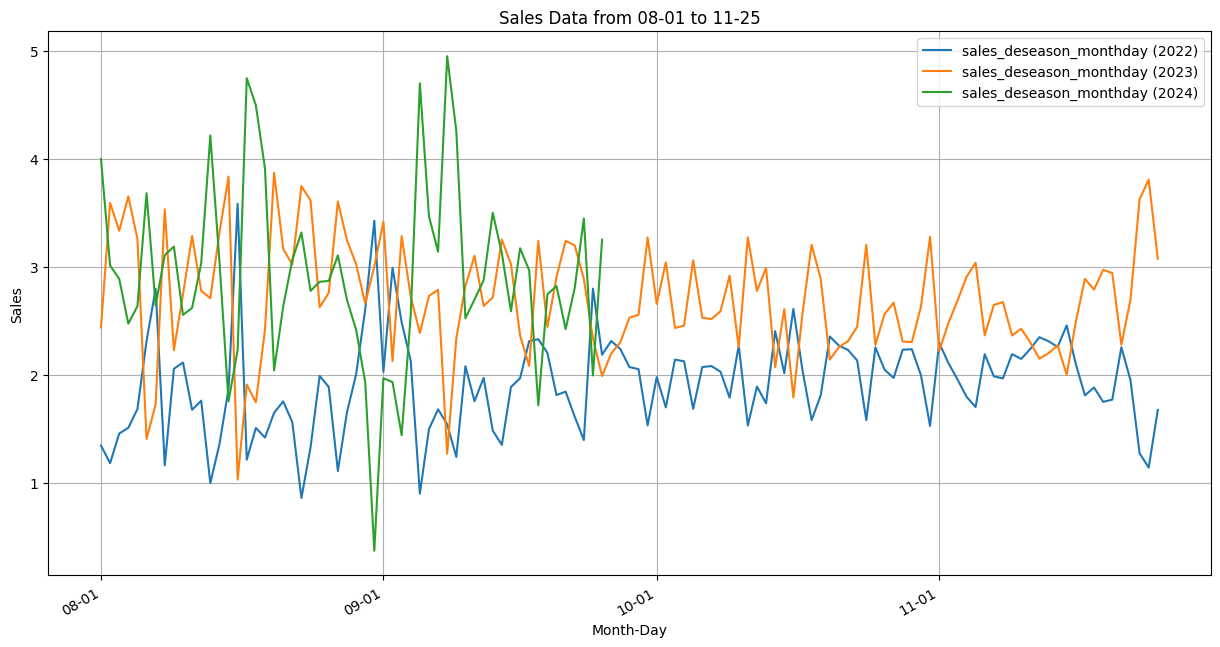

In [93]:
plot_sales([train_df["sales_deseason_monthday"]],
           ["sales_deseason_monthday"]
          ,start_month_day="08-01", end_month_day="11-25")

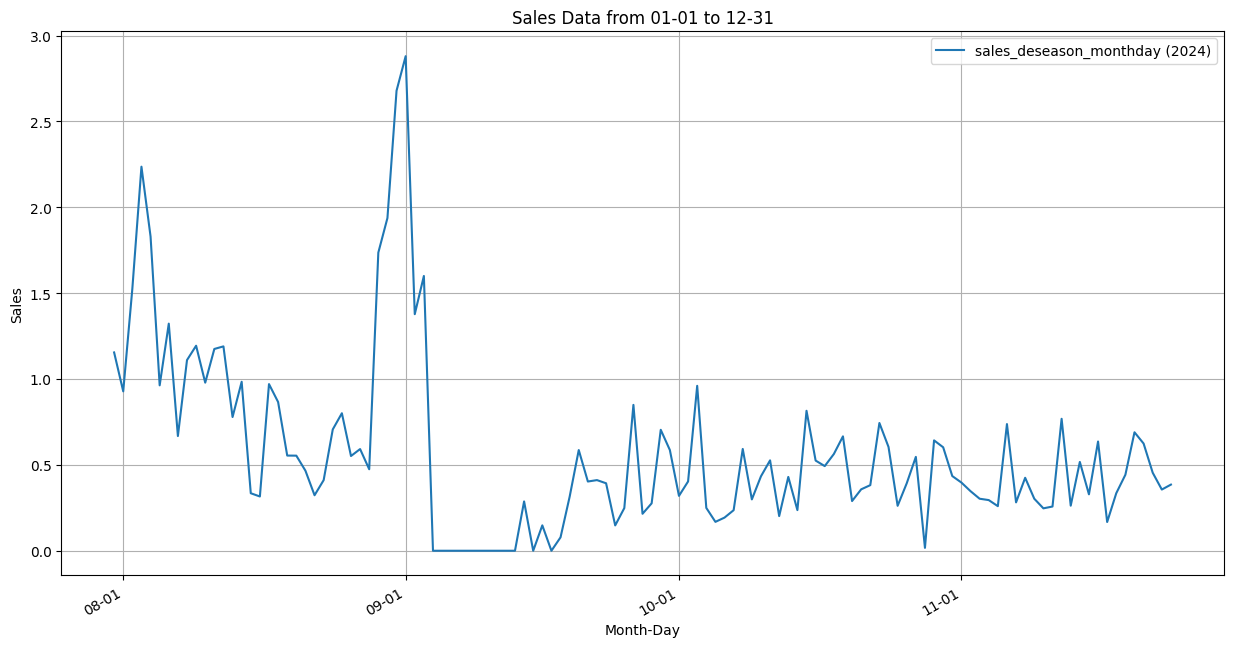

In [89]:
plot_sales([df_new["sales_deseason_monthday"]],
           ["sales_deseason_monthday"]
          ,start_month_day="01-01", end_month_day="12-31")

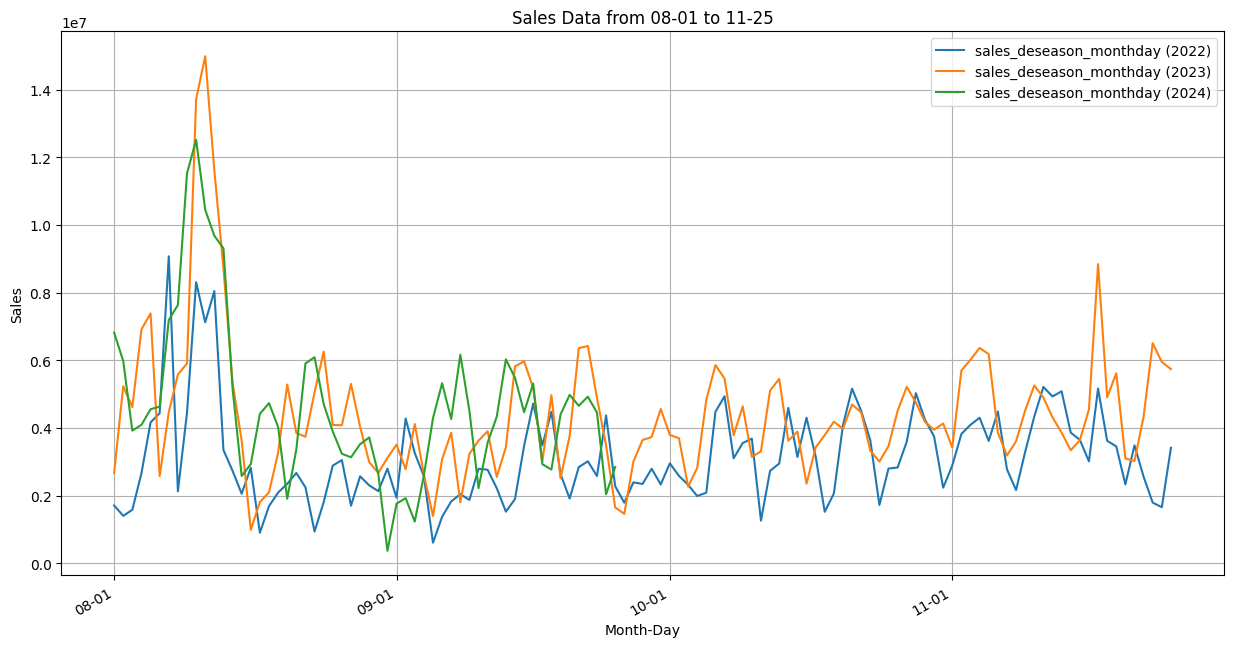

In [95]:
plot_sales([train_df["sales"]],
           ["sales_deseason_monthday"]
          ,start_month_day="08-01", end_month_day="11-25")

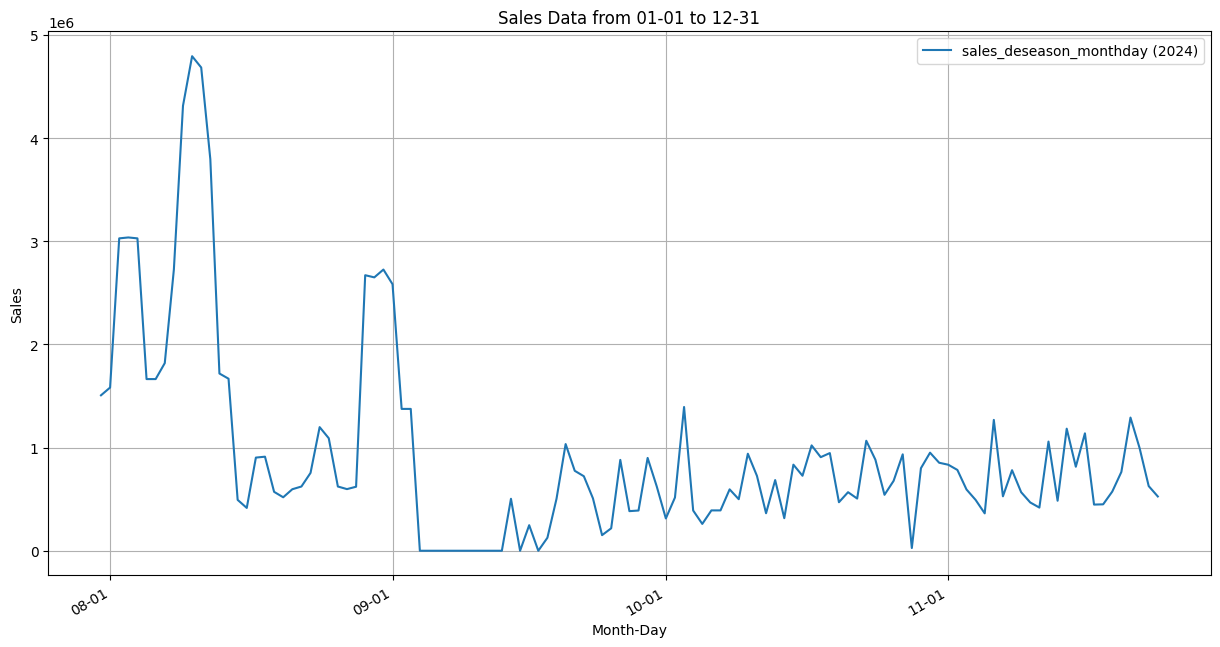

In [91]:
plot_sales([df_new["sales"]],
           ["sales_deseason_monthday"]
          ,start_month_day="01-01", end_month_day="12-31")

In [90]:
df_new["sales_deseason_monthday"]

date
2024-07-31    1.154841
2024-08-01    0.928222
2024-08-02    1.525902
2024-08-03    2.236554
2024-08-04    1.829859
                ...   
2024-11-20    0.689836
2024-11-21    0.624328
2024-11-22    0.454235
2024-11-23    0.356353
2024-11-24    0.385182
Name: sales_deseason_monthday, Length: 117, dtype: float64

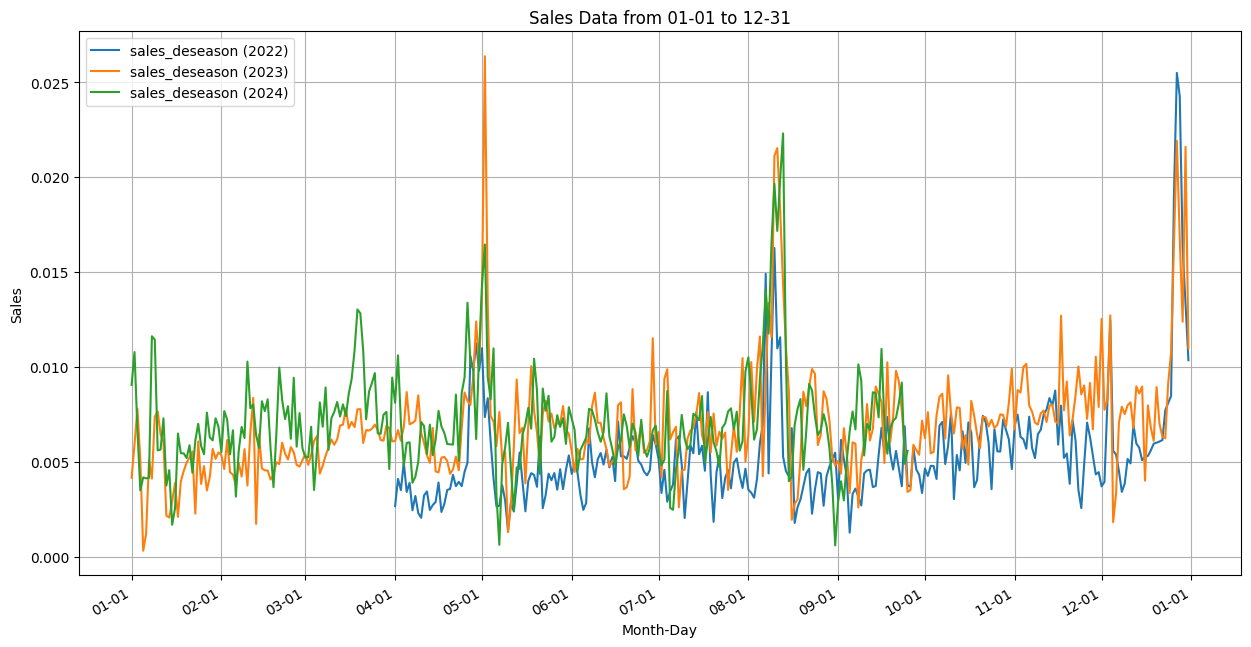

In [87]:
train_df["sales_deseason"] /= 10000000000
df_new["sales_deseason"] /= 10000000000

plot_sales([train_df["sales_deseason"]],
           ["sales_deseason"]
          ,start_month_day="01-01", end_month_day="12-31")

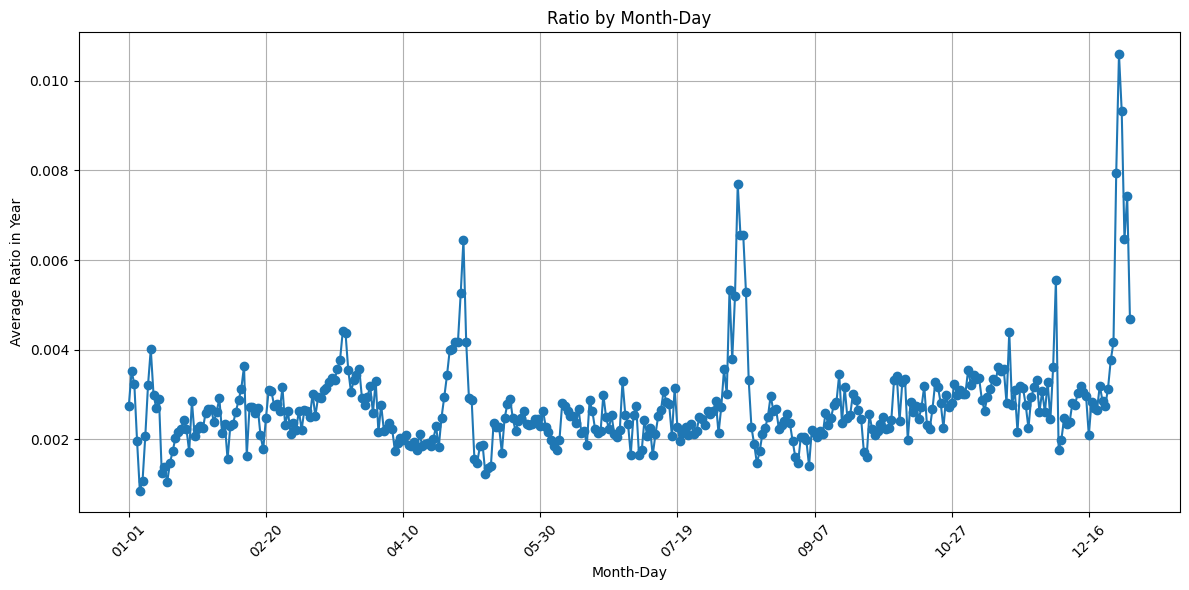

In [69]:
# 月日をx軸にするための準備
ratio_by_monthday.index = ratio_by_monthday.index.map(lambda x: f"{x[0]:02d}-{x[1]:02d}")

# 図を作成
plt.figure(figsize=(12, 6))
ratio_by_monthday.plot(kind="line", marker="o", title="Ratio by Month-Day")
plt.xlabel("Month-Day")
plt.ylabel("Average Ratio in Year")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# train_df, val_df, test_df, ensemble = main_flow_with_dow(df,0)
train_df, test_df= main_flow_with_dow(df,0)

Optimal Weights: [2.81389941e-18 9.49060867e-01 5.08262754e-02 8.39570723e-19
 1.38777878e-17 4.68624296e-18 1.12857185e-04]
Optimal Weights: [1.44179400e-01 2.23089915e-01 2.66137257e-01 4.16333634e-17
 1.97129274e-01 1.69464154e-01 0.00000000e+00]


In [14]:
mean_absolute_percentage_error(test_df["sales"], test_df["forecast"], freq='W', start_date=test_df.index[0])

(6.044486568756332,
               y_true        y_pred
 2024-09-29  19288080  1.859315e+07
 2024-10-06  30138720  3.101657e+07
 2024-10-13  28518240  3.272023e+07
 2024-10-20  33652800  3.104924e+07
 2024-10-27  29670480  3.209197e+07
 2024-11-03  33909360  3.385632e+07
 2024-11-10  30298800  3.325633e+07
 2024-11-17  32636880  3.492397e+07
 2024-11-24  32003520  3.210827e+07,
 2024-09-29     3.602876
 2024-10-06     2.912690
 2024-10-13    14.734385
 2024-10-20     7.736525
 2024-10-27     8.161278
 2024-11-03     0.156427
 2024-11-10     9.761209
 2024-11-17     7.007688
 2024-11-24     0.327300
 Freq: W-SUN, dtype: float64)

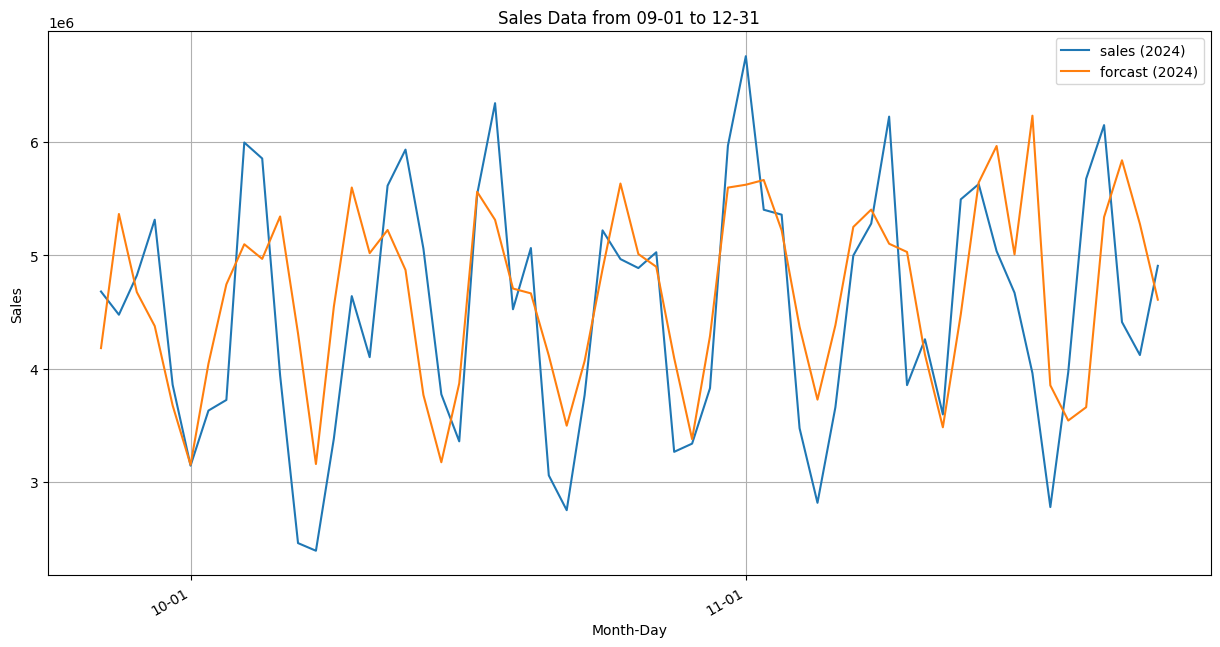

In [15]:
# Call the function
plot_sales([test_df["sales"], test_df["forecast"]],
           ["sales", "forcast"]
          ,start_month_day="09-01", end_month_day="12-31")